<a id='part1'></a>
# <span style="color:navy">Part 1: Open-Loop Control</span>

## 1.0 Introduction to Open-Loop Control

We will begin by exploring how to control our car using **open-loop control**. Open-loop control refers to a controller that does not take in feedback from the target system; it blindly sets the inputs to what it calculates based on the model.

 For S1XT33N, open loop control will attempt to calculate the inputs $u_L$ and $u_R$ to make both wheels run at the same velocity v* (the operating velocity we calculated in the previous lab). 

**First, fill in your model parameters and target velocity from Lab 6: System ID below.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [2]:
# YOUR PARAMETERS HERE
theta_left = 0.6101
theta_right = 0.611
beta_left = 11.68
beta_right = 11.77
v_star = 34.1

simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [3]:
params = np.array([(theta_left, theta_right),
                   (beta_left, beta_right)])
d0 = (0,  0)
sim_length = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

<a id='part1.1'></a>
## 1.1 Open-Loop Controller Design

Use the linear model parameters you calculated in the previous lab to design your open-loop controller. Your controller takes in the desired wheel velocity, $v_{star}$, and returns the motor inputs, $u_L$ and $u_R$, to set the model wheel velocities to $v_{star}$.

Tip: Since we defined your parameters $\theta_L$, $\theta_R$, etc in a code block above, you can use those same variables within your open-loop functions.

In [4]:
# DESIGN YOUR OPEN-LOOP CONTROL HERE
def drive_straight_left_ol(v_star):
    """Returns the open loop input 'u' for the left wheel"""
    u_l = (v_star + beta_left)/ theta_left
    #raise NotImplementedError() # REMOVE THIS LINE
    return u_l

def drive_straight_right_ol(v_star):
    """Returns the open loop input 'u' for the right wheel"""
    u_r = (v_star + beta_right) / theta_right
    #raise NotImplementedError() # REMOVE THIS LINE
    return u_r

<a id='part1.2'></a>
## 1.2 Open-Loop Simulation


Now, let's do a quick simulation to check the behavior of the car based on our functions above.

### Mismatch
 There could be a mismatch between the estimated model parameters $\beta_{L,R}, \theta_{L,R}$ and real model parameters $\beta^*_{L,R}, \theta^*_{L,R}.$ In this simulation, we assumed that the mismatch error is the same for both $\beta_{L,R}$ and $\theta_{L,R}$


$$\theta^*_{L,R}=\theta_{L,R} \times (1+\text{mismatch\_error})$$
$$\beta^*_{L,R}=\beta_{L,R} \times (1+\text{mismatch\_error})$$


In the left two plots, we assume the physical system perfectly matches our model. On the right, we assume the physical system is 10% different from our model, meaning the model parameters of the wheels have a 10% mismatch. Don't worry too much about the $\delta$ (delta) plot for now; we will come back to what this is later on in the lab.

The 5th plot titled "Trajectory of the car" shows how the car would travel depending on which model is used. In the perfect model, the car is driving straight. In the case with model mismatch, the car continues to spin right.


Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = unbounded


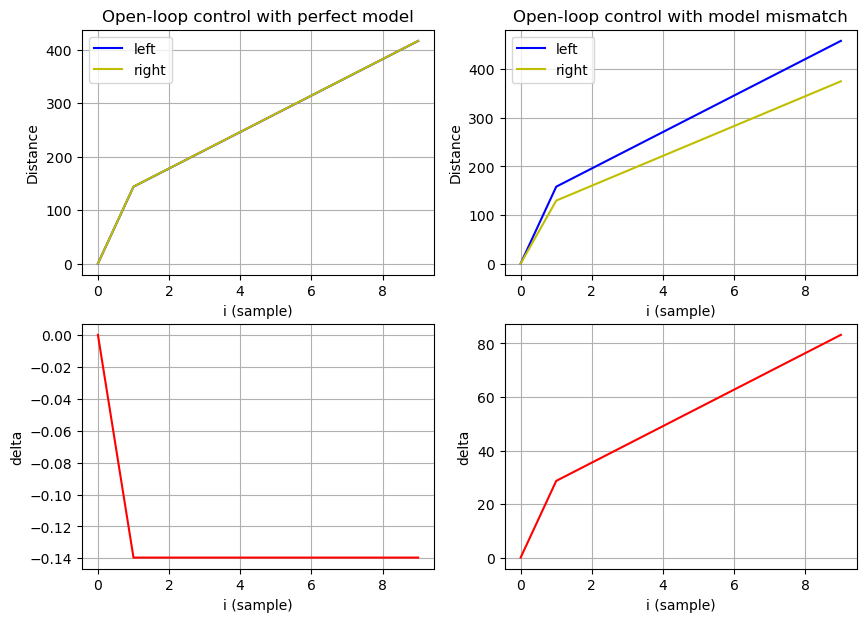

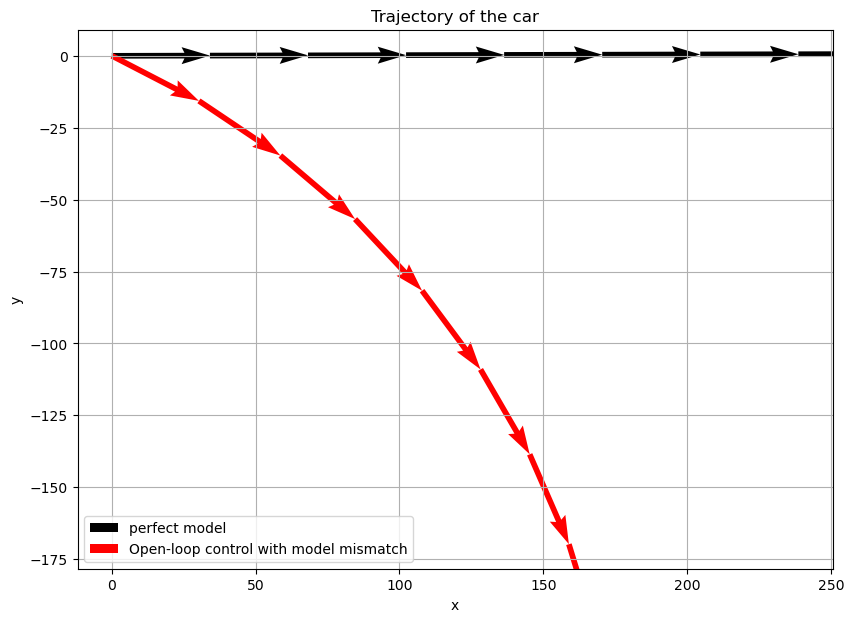

In [5]:
titles = ["Open-loop control with perfect model",
          "Open-loop control with model mismatch"]
_ = utils.two_sims(titles, simulator, v_star, drive_straight_left_ol, drive_straight_right_ol)
utils.plot_car_traj(titles[1], simulator, v_star, drive_straight_left_ol, drive_straight_right_ol,mismatch_error=0.1,sim_length=sim_length)

<a id='part1.3'></a>
## 1.3 Jolt Calculation

When starting our motors from rest, we need to apply a large initial PWM to overcome static friction and "jolt" the motors into motion. However, as each side responds differently to the input; doing so could cause the car to immediately turn at the start and veer off course. 

Thus, we need to calculate jolt values that result in the two wheels attaining the same velocity, which we will choose to be the maximum velocity attainable by both wheels. This is equivalent to min(max(v_left), max(v_right)).

- **Copy your `data_coarse.txt` file from Lab 6 into the same directory as this notebook.**
- Run the code below to find and print your initial jolt values.
- These jolt values should be the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

int left_jolt = 240;
int right_jolt = 200;


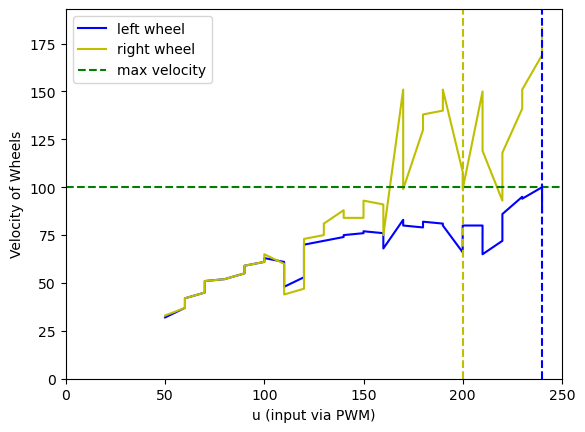

In [6]:
left_jolt, right_jolt = utils.find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

<a id='part1.4'></a>
## 1.4 Open-Loop Implementation

Now we will implement the controller on the Arduino. The sketch **`open_loop.ino`** contains some code that implements open-loop control.

- **If you've changed any of the pins from their default values in System ID, make sure those changes are reflected in the pin definitions.**

- Fill in these values in `CODE BLOCK CON1`:
    - estimated parameters: `theta_left`, `theta_right`, `beta_left`, `beta_right`
    - desired velocity: `v_star` 
    - initial jolt values: `left_jolt`, `right_jolt`
- Additionally, we need to compute the PWM input to the motors in `CODE BLOCK CON2`:
    - Complete `driveStraight_left()` and `driveStraight_right()` to compute `left_cur_pwm` and `right_cur_pwm`
    - This is similar to the `drive_straight_left_ol` and `drive_straight_right_ol` functions you wrote above, but now using C/C++ syntax instead of Python.
    - Tip: Your $\theta$ and $\beta$ values are defined globally at the top of the .ino file, so you can reference them inside your function.
- Fill out `CODE BLOCK CON3` to calculate the control inputs using the functions from `CODE BLOCK CON2`.

- Upload the sketch to your Arduino. Suspend your car over your desk and verify that your motors work as expected.

Once you are satisfied that your open loop control is implemented, run your car on the ground. 

Most likely, S1XT33N will not drive in a straight line: you will see that it is still turning quite a bit. In the next section, we will use closed-loop control to use feedback to drive in a straight line.

<a id='part2'></a>
# <span style="color:navy">Part 2: Closed-Loop Control</span>

<a id='part20'></a>
## 2.0 Introduction to Closed-Loop Control

To correct for the limitations of open-loop control, we need a way to detect that the car is turning. Fortunately, we already have encoders that can measure the distance traveled by each wheel. We can take this information and "feed it back" to the Arduino as an input so that it can correct the trajectory. This is the basis for a closed-loop controller.


<a id='part21'></a>
## 2.1 Closed-Loop Design

We define $\delta[i] = d_L[i] - d_R[i]$, the difference between the distances traveled by the left and right wheels.
Our closed-loop controller takes the $\delta$ value and adjusts the left and right inputs to correct for turns or disturbances. We define feedback factors $f_{left}$ and $f_{right}$ to control the amount of correction of each wheel. 

In Parts 2.1-2.4, the goal of our closed-loop controller is to converge S1XT33N's trajectory to a straight line in a reasonable amount of time. It is okay if the car starts off turning and then drives in a straight line; we will correct for this in Part 2.5.

Using the model derived in the lab note, we can begin implementing the closed-loop controller.

Start by running the code below to set up the simulator and fill in `drive_straight_left_cl` and `drive_straight_right_cl`, which compute the wheel inputs using the desired velocity `v_star`, error term `delta`, and feedback factors `f_left` and `f_right` (which will be defined in the next section).

In [7]:
simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [8]:
# DESIGN YOUR CLOSED-LOOP CONTROL HERE USING f_left AND f_right AS YOUR FEEDBACK TERMS
def drive_straight_left_cl(v_star, delta):
    """Returns the closed loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    #raise NotImplementedError() # REMOVE THIS LINE
    return (v_star - f_left*delta + beta_left)/theta_left

def drive_straight_right_cl(v_star, delta):
    """Returns the closed loop input 'u' for the right wheel"""
    # YOUR CODE HERE
    #raise NotImplementedError() # REMOVE THIS LINE
    return (v_star + f_right*delta + beta_right)/theta_right


<a id='part22'></a>
## 2.2 Closed-Loop Simulation and f-Value Selection

With the input-calculating functions implemented, we will choose feedback factor values to stabilize the $\delta[i]$ update equation. There should be a range of parameter values which (theoretically) make it stable, so we will tune the gains to achieve the desired performance.

Take a look at each pair of perfect/mismatched-model plots below for each f-value pair and relate how our choice in f-values affects the car's performance. For each pair of plots, ask yourself these questions:
1. Does the car seem to drive straight in the perfectly matched model?
2. Does the car seem to correct for any errors that arise from a mismatched model? Does it end up driving straight?
3. How well does the car correct for errors?
3. Why do the chosen f-values make our system exhibit such behaviors?

Try the 5 different sets of gains below and see the effect of each.

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = unbounded
fL=-0.3, fR=0.3
Eigenvalue of system: 1-fL-fR=1; marginally stable


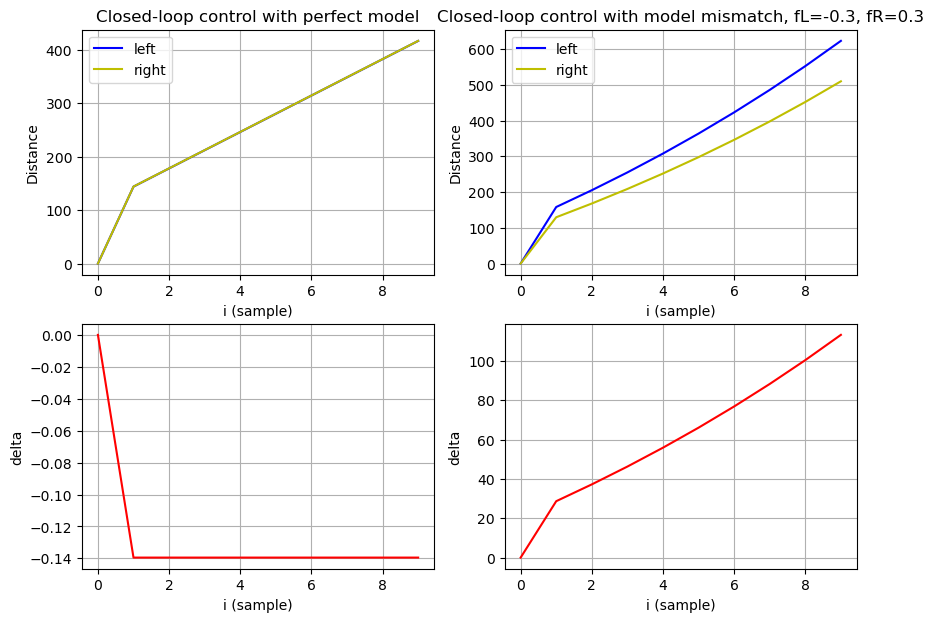

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 6.82
fL=0.5, fR=0.5
Eigenvalue of system: 1-fL-fR=0; stable, corrects error in one step


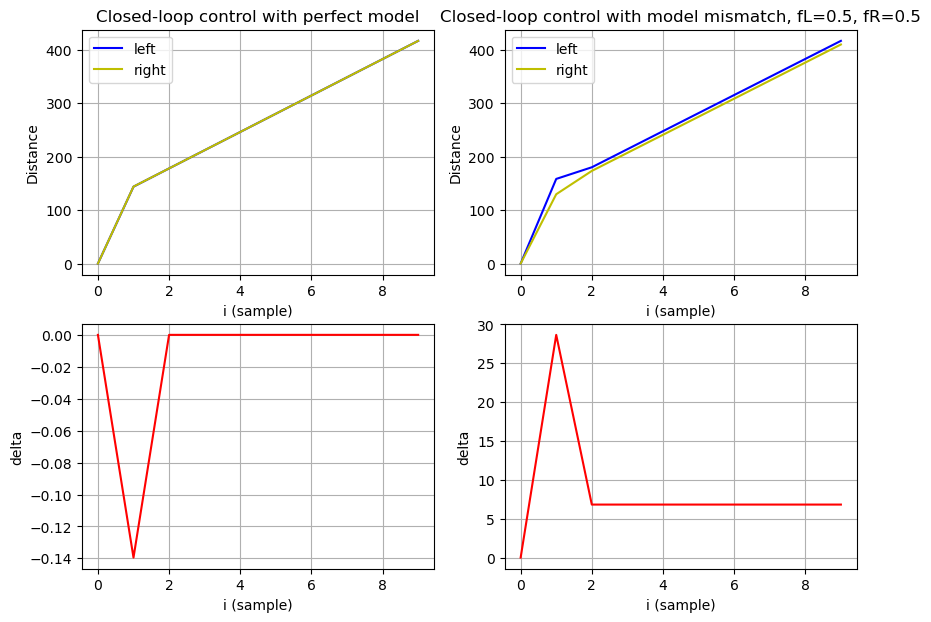

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = oscillatory
fL=1, fR=1
Eigenvalue of system: 1-fL-fR=-1; oscillatory, marginally stable


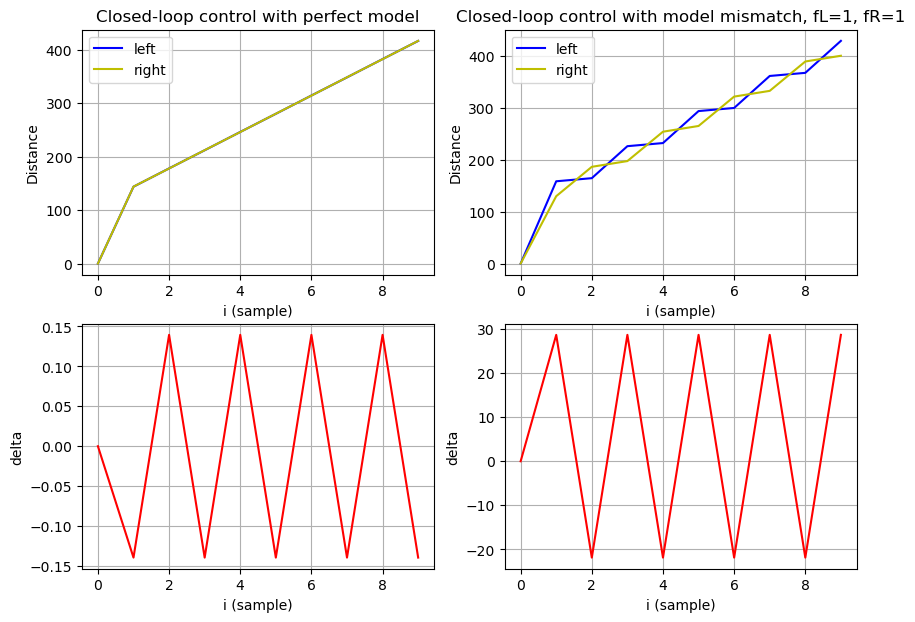

Perfect model: Steady state error = unbounded
Non-ideal model: Steady state error = oscillatory
fL=1.1, fR=1.1
Eigenvalue of system: 1-fL-fR=-1.2; oscillatory, unstable


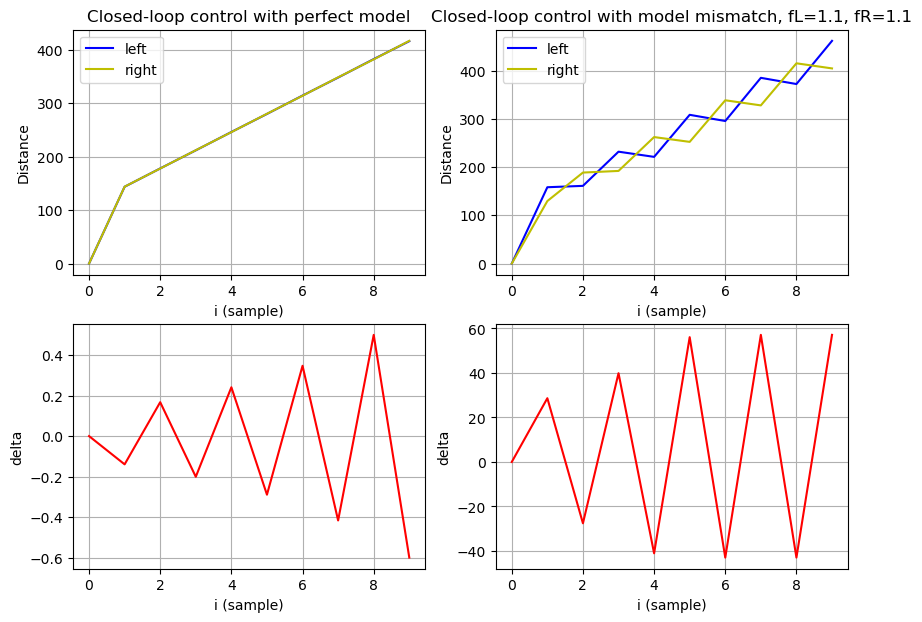

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 17.24
fL=0.2, fR=0.2
Eigenvalue of system: 1-fL-fR=0.6; stable


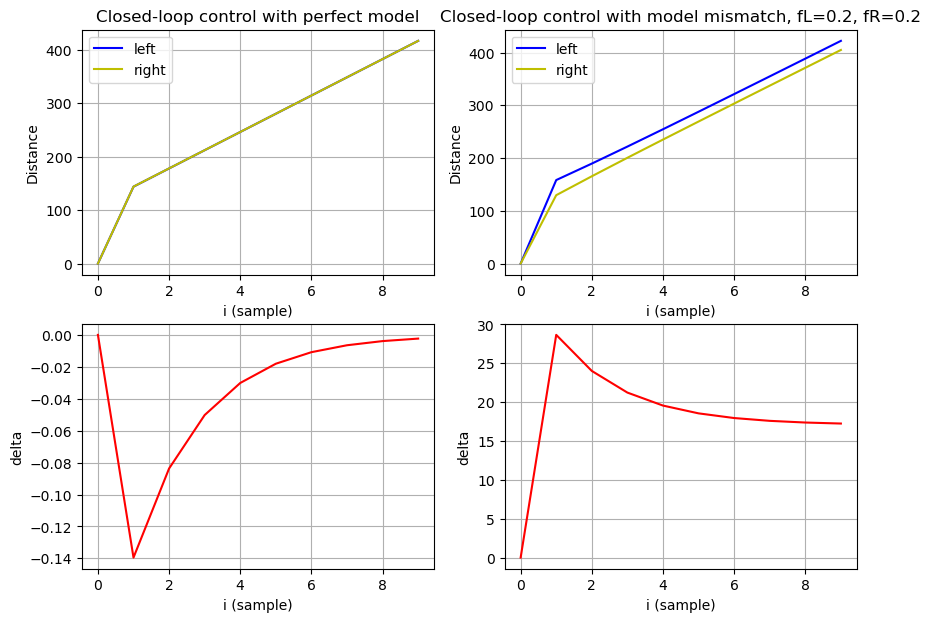

In [9]:
# Maps description of f_values to (f_left, f_right)
f_values = {
    "marginally stable": (-0.3, 0.3),
    "stable, corrects error in one step": (0.5, 0.5),
    "oscillatory, marginally stable": (1, 1),
    "oscillatory, unstable": (1.1, 1.1),
    "stable": (0.2, 0.2),
}

for key in f_values:
    f_left, f_right = f_values[key]

    titles = ["Closed-loop control with perfect model",
              "Closed-loop control with model mismatch, fL={}, fR={}".format(f_left, f_right)]
    _, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

    print("fL={}, fR={}".format(f_left, f_right))
    print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
    plt.show()
    steady_state_error = delta[-1]

Now that you've taken a look at the behavior of various values for $f_{left}$ and $f_{right}$, choose your own for your car model! Fill in your chosen values in the code below to see how your model behaves. Does it do what you expected it to?

Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 6.14
fL=0.6, fR=0.5
Eigenvalue of system: 1-fL-fR=-0.1; stable


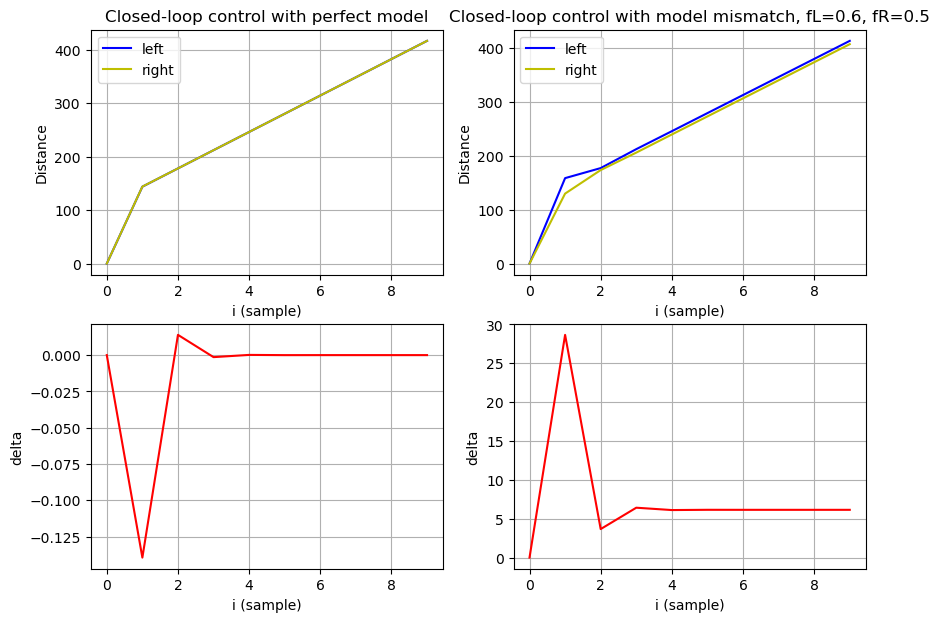

In [12]:
f_left, f_right = 0.6, 0.5 # TODO: Fill in your chosen f values

titles = ["Closed-loop control with perfect model",
          "Closed-loop control with model mismatch, fL={}, fR={}".format(f_left, f_right)]
_, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

print("fL={}, fR={}".format(f_left, f_right))
print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
plt.show()
steady_state_error = delta[-1]

<a id='part23'></a>
## 2.3 Closed-Loop Implementation

Now implement the controller on the Arduino. The sketch **`closed_loop.ino`** contains some code that implements the closed loop control. 

- If you've changed any of the pins from their default values, make sure those changes are reflected in the pin definitions.
- Fill out `CODE BLOCK CON1` with your control gains **`f_left`** and **`f_right`** as well as your $\theta$, $\beta$, and $v_{star}$ values from System ID.
    - Finding the values that work best for your car is an iterative process, and you'll have to tune these values.
- Fill out `CODE BLOCK CON2` with your closed-loop control scheme.
- Fill out `CODE BLOCK CON4` in the body of the loop function to calculate the control inputs. Inspect this code to see how the control system is implemented. 
    - Ignore the term `delta_ss` for now. We will implement this in a bit.
- Upload the sketch to your Arduino. Suspend your car over your desk and verify that your motors work as expected.
    - A good sanity check is to manually hold one wheel in place; the controller should cause the other wheel to stop as well.

Once you are satisfied that your closed loop control is implemented, run your car on the ground. 

-----

<a id='part24'></a>
## 2.4 f-Value Tuning

How did the car behave? It probably didn't go perfectly straight with the first set of f-values that you picked. To find the optimal f values, we will analyze the behavior of our car. For our system, we want $\delta[i]$ (the blue line) to converge to 0 in a reasonable amount of time.

small f-values | large f-values
- | - 
![alt](images/small_f.png) | ![alt](images/large_f.png)
 
The above plots can be summarized as:
- If $f_{left}$ and $f_{right}$ are too small, convergence takes a long time.
- If $f_{left}$ and $f_{right}$ are too big, the system oscillates.
We can use this information to select f-values for straight motion.

With this in mind, try different f-values and run the car on the ground again, observing its trajectory. This is an iterative process and you will likely have to try several sets of f-values until you find one that works well for your particular car. 

**<span style="color:green">What sets of f-values did you try? Why?</span>**

f values within |1-fl-fr| < 1

<a id='part25'></a>

## 2.5 Steady State Error Correction

Oftentimes, delta will converge to some non-zero constant rather than zero. This means that the car eventually converges to driving straight, but with a different bearing (i.e. the car turned initially but then drives straight). However, we want the car to travel in (approximately) the same direction as when it started moving. 

We can accomplish this by manually adding the known steady state error $\delta_{ss}$ to each calculation of the error $\delta$.
We define our new error term as $\delta[i]=d_L - d_R + \delta_{ss}$.


Steady state error = 0.00


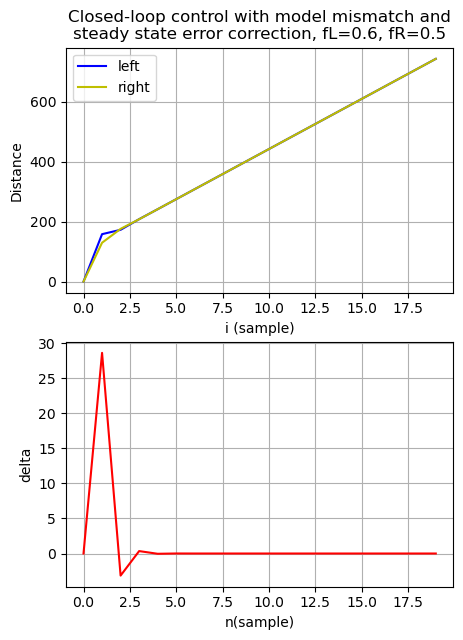

In [13]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
d = simulator.simulate(
    v_star, drive_straight_left_cl, drive_straight_right_cl, mismatch_error=0.1, sim_length=20, offset=steady_state_error)
delta = simulator.plot(d)
plt.title("Closed-loop control with model mismatch and\nsteady state error correction, fL={}, fR={}"
          .format(f_left, f_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')
plt.xlabel('n(sample)')
plt.grid()



# ard
# #define LEFT_MOTOR                  6
# #define LEFT_ENCODER                3
# #define RIGHT_MOTOR                 5
# #define RIGHT_ENCODER               2


# #define RXLED 17
# #define TXLED 30

# #define RUN_TIME                    (20*1000)
# #define SAMPLING_INTERVAL           100
# #define SAMPLE_LEN                  (RUN_TIME/SAMPLING_INTERVAL)

# #define JOLT_STEPS                  2

# int step_num = 0;
# volatile int left_count = 0;
# volatile int right_count = 0;

# int16_t deltaArr[SAMPLE_LEN] = {0};
# int16_t lpos[SAMPLE_LEN] = {0};
# int16_t rpos[SAMPLE_LEN] = {0};
# uint8_t lpwm[SAMPLE_LEN] = {0};
# uint8_t rpwm[SAMPLE_LEN] = {0};

# /*---------------------------*/
# /*      CODE BLOCK CON1      */
# /*     From open_loop.ino    */
# /*       with changes        */
# /*---------------------------*/
# float theta_left = 0.6101;
# float theta_right = 0.611;
# float beta_left = 11.68;
# float beta_right = 11.77;
# float v_star = 34.1;

# // PWM inputs to jolt the car straight
# int left_jolt = 240;
# int right_jolt = 200;

# // Control gains
# float f_left = 0.6;
# float f_right = 0.6;
# /*--------------------------*/
# /*---------------------------*/
# /*---------------------------*/


# /*---------------------------*/
# /*      CODE BLOCK CON2      */
# /*---------------------------*/
# float driveStraight_left(float v_star, float delta) {
#   return (v_star - f_left*delta + beta_left)/theta_left;
# }

# float driveStraight_right(float v_star, float delta) {
#   return (v_star + f_right*delta + beta_right)/theta_right;
# }
# /*---------------------------*/
# /*---------------------------*/
# /*---------------------------*/


# /*---------------------------*/
# /*      CODE BLOCK CON3      */
# /*---------------------------*/
# float delta_ss = 0;
# /*---------------------------*/
# /*---------------------------*/
# /*---------------------------*/

# void setup() {
#   Serial.begin(38400);

#   pinMode(LEFT_MOTOR, OUTPUT);
#   pinMode(LEFT_ENCODER, INPUT);
#   pinMode(RIGHT_MOTOR, OUTPUT);
#   pinMode(RIGHT_ENCODER, INPUT);
  
#   pinMode(LED_BUILTIN, OUTPUT);
#   pinMode(RXLED, OUTPUT);
#   pinMode(TXLED, OUTPUT);
#   delay(500);

#   write_pwm(0, 0);
#   digitalWrite(LED_BUILTIN, HIGH);
#   digitalWrite(TXLED, LOW);
#   digitalWrite(RXLED, LOW);
#   delay(1000);
#   digitalWrite(LED_BUILTIN, LOW);
#   delay(1000);
#   digitalWrite(TXLED, HIGH);
#   delay(1000);
#   digitalWrite(RXLED, HIGH);
#   delay(1000);
  
#   attachInterrupt(digitalPinToInterrupt(RIGHT_ENCODER), flag_right, CHANGE);
#   attachInterrupt(digitalPinToInterrupt(LEFT_ENCODER), flag_left, CHANGE);
# }

# void loop() {
#   if (step_num < JOLT_STEPS) {
#     write_pwm(left_jolt, right_jolt);
#     step_num++;

#     digitalWrite(RXLED, (step_num / 5) % 2);
#     digitalWrite(TXLED, ((step_num / 5) + 1) % 2);
#   }
#   else if (step_num < SAMPLE_LEN) {
#     // Save positions because left_position and right_position
#     // can change in the middle of one loop.
#     int left_position = left_count;
#     int right_position = right_count;

#     /*---------------------------*/
#     /*      CODE BLOCK CON4      */
#     /*---------------------------*/
#     /*--------------------------------------*/
#     /*     Add the steady-state value of    */
#     /*    delta from this calculation to    */
#     /*    compensate for initial turning    */
#     /*--------------------------------------*/
#     float delta = left_position - right_position + delta_ss;
    
#     // Drive straight using feedback
#     // Compute the needed pwm values for each wheel using delta and v_star
#     int left_cur_pwm =  driveStraight_left(v_star, delta);
#     int right_cur_pwm = driveStraight_right(v_star, delta);
#     write_pwm(left_cur_pwm, right_cur_pwm);
#     /*---------------------------*/
#     /*---------------------------*/
#     /*---------------------------*/

#     lpos[step_num] = left_position;
#     rpos[step_num] = right_position;
#     deltaArr[step_num] = delta;
#     lpwm[step_num] = left_cur_pwm;
#     rpwm[step_num] = right_cur_pwm;

#     step_num++;
#     digitalWrite(RXLED, (step_num / 5) % 2);
#     digitalWrite(TXLED, ((step_num / 5) + 1) % 2);
          
#   } else {
#     write_pwm(0, 0);
#     digitalWrite(RXLED, HIGH);
#     digitalWrite(TXLED, HIGH);
    
#     if (Serial.available() > 0) {
#       if ( Serial.read() == 10){
#        print_vals(); 
#       }
#     }
#   }
#   delay(SAMPLING_INTERVAL);
# }

# /*---------------------------*/
# /*     Helper functions      */
# /*---------------------------*/

# void write_pwm(int pwm_left, int pwm_right) {
#   analogWrite(LEFT_MOTOR, (int) min(max(0, pwm_left), 255));
#   analogWrite(RIGHT_MOTOR, (int) min(max(0, pwm_right), 255));
# }

# void flag_left() {
#   if(digitalRead(LEFT_ENCODER)) {
#     left_count++;
#   }
# }

# void flag_right() {
#   if(digitalRead(RIGHT_ENCODER)) {
#     right_count++;
#   }
# }

# void print_vals() {
#   Serial.println("delta");
#   for (int i = 0; i < SAMPLE_LEN; i++) {
#      Serial.println(lpos[i] - rpos[i]);
#   }
# }

`closed_loop.ino` collects data as it runs, keeping track of $\delta[i]$ over time. Like `dynamics_data.ino` from the System ID lab, data will be stored in local memory as long as power to the Arduino is not cut off. After you have finished tuning your f-values, do the following:
- Upload the `closed_loop.ino` program again and let the car run until it settles to (approximately) straight; it should do so by the time it naturally comes to a stop.
- With the Arduino still powered by `Vin`, plug in the USB and open the Serial monitor. Type any character into the input box and hit enter. Your data will be printed into the Serial Monitor.
- Note the values of $\delta$.
    - **If $\delta$ doesn't converge (reaches steady state), the car is not going straight according to the sensors.**
        - It's okay if it isn't exactly constant (ie $\pm 1$)
    - The value that the $\delta$ converges to is the $\delta_{ss}$ value.

## Implementing Steady State Error Correction

- Input your value of $\delta_{ss}$ in `CODE BLOCK CON3` in **`closed_loop.ino`**.
- Make sure you understand why you *add* this value in `CODE BLOCK CON4`.
    - For example, if the car drives straight but turned right from its initial heading, we want the right wheel to travel farther so it turns back towards the left. Adding a positive number to delta accomplishes this.
- Reupload the `closed_loop.ino` program, unplug the Arduino from the computer, and run your car on the ground to observe its behavior with steady state error correction.

<a id='part3'></a>
# <span style="color:navy">Part 3: Turning</span>

## 3.1 Analyzing a Turn

Suppose we want to turn with a specific radius by manually adding some $\delta_{ref}$ to our $\delta$ value at each step of the control scheme. For more background information, please refer to the lab note. Inspect the following diagram that represents the geometry of a turn:

<center>
<img width="400px" src="images/turning_figure.png">
</center>

From this geometry, can write $\delta_{ref}[i]$ in the following form?
$$\delta_{ref}[i] = f(r,v^*,l,i)$$

Note that Arc length = radius * central angle.

Hint 1:  Write $d_l$ and $d_r$ in terms of their radii and $\theta$.
<br>
Hint 2: How can we relate $v*$ to $\theta$?


<h3><span style='color:red'>**Check your answer with lab staff!**</span></h3>

l*(v*i)/r

## 3.2 Implementing a Turn

### Sampling periods 
 
 Our implementations of data collection and control loop have different time periods: data collection collected data on half-second intervals, while our controller updates the trajectory every 0.1 seconds. This means that our controller will be running at a faster rate than our data collection. However, our definition of the time step is dependent on the sampling period we use, so we will need to account for this difference by adjusting $v^*$ in our implementation of turning.

Let the sampling periods of the control loop and the data collection be $T_c$ and $T_d$, which have the units $\frac{s}{sample}$. Therefore,their respective sampling frequencies $F_c = \frac{1}{T_c}$ and $F_d = \frac{1}{T_d}$ have the units $\frac{samples}{s}$. We define $m=\frac{F_c}{F_d}$, the ratio of the sampling frequencies.

Our controller will interpret velocity in terms of distance traveled (measured in encoder ticks) per sample ($\frac{ticks}{sample}$). However, we need to ensure the car is travelling at the same ground velocity, which is measured per second ($\frac{ticks}{s}$). To get a constant $\frac{ticks}{s}$, we need $v^*_c \cdot F_c = v^* \cdot F_d$.

Solving for $v^*_c$, we get $v^*_c = v^* \cdot \frac{F_d}{F_c} = \frac{v^*}{m}$

Plugging in our values of $T_c=100ms$ and $T_d=500ms$, we can calculate that $F_c=10$, $F_d=2$, and $m=5$.

During data collection, we sampled every $.5$ seconds. If our $v^*$ was collected to be $100$ ticks/sample, this means that we expect our car to move $100$ ticks every $.5s$ (assuming constant velocity). Now, our controller's sampling rate is instead $.1$ seconds. If we use the same $v^*$ of $100$ ticks/sample, we are now expecting our car to move $100$ ticks in $.1s$, effectively quintupling our velocity! Our controller does not have information about the original sampling period; to account for this, we divide $v^*$ by $5$ when using a $v^*$ value for turning.

**<span style='color:red'> In your delta_reference function, use $\frac{v^*}{m}$ instead of $v^*$. Do not replace the original $v^*$ parameter defined in `CODE BLOCK CON1`!</span>**

### Implementation
- Open `turning.ino`.
- Copy the required code from `closed_loop.ino` into **`CODE BLOCK CON1/2/3`**
    - <span style='color:red'>**Note that your `driveStraight` functions only have one parameter in this program unlike closed_loop.ino, so only copy over the body of the functions!**</span>
- **Complete the function `delta_reference` in `CODE BLOCK CON5`**.
    - Look at `CODE BLOCK CON0` to see how this is used
    - **Use $\frac{v^*}{m}$ instead of $v^*$ in your delta_reference function!**
    - Use the variables `TURN_RADIUS`, `v_star`, `CAR_WIDTH`, and `i` (the time-step).
    - `delta_ss` is used in `CODE BLOCK CON0`, so don't include it here.
- The commands your car follows are defined in **`PREPROGRAMMED PATH`**
    - `NUM_COMMANDS`: number of commands your car will follow. The default is set as 4.
    - `run_times` and `drive_modes`: arrays that store the time and mode of each command
    - The commands your car follows as well as the run time associated with each command is in the 
        - The number of elements in both `drive_modes` and `run_times` is equal to `NUM_COMMANDS`
        - `drive_modes` can take on values: `[DRIVE_STRAIGHT, DRIVE_LEFT, DRIVE_RIGHT]`.
        - Try to tune your `run_time` and `turn_radius` for the turns such that the car turns approximately 90 degrees.
            - **The values in `run_times` are in ms**, so you should have run times that are at least 1000.
            - If your car doesn't turn with the same speed when turning left vs right, you can adjust the run times of the left and right turns to be different values.
        
**Remember**: If you have previously changed out any pins, you will need to update those pin assignments in `turning.ino` accordingly!

When you're done, try it out! S1XT33N should follow the preprogrammed path we provided as a default. If you'd like, feel free to play around with implementing different paths by changing the commands under `PREPROGRAMMED PATH`.

## Part 3.3: Correcting Mechanical Errors

At this stage, your car may already go perfectly straight and turn left and right equally. However, some cars may still turn very slightly even when both encoder measurements are exactly the same ($\delta=constant$). This can be caused by mechanical issues such as axle wobble or mismatch in the wheel sizes. In this case, since the car thinks it's driving straight, it's the best we can do using just the sensors in our control system.

One way we can correct it for this behavior is by instructing the car to turn very slightly when trying to drive straight. If you think your car could benefit from this, implement the function `straight_correction` in `CODE BLOCK CON6` using the variable `STRAIGHT_RADIUS`. Update this value from INFINITY to a suitably large number.